In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# Standard library imports
import json
import logging
import os
import random
from datetime import datetime
from pathlib import Path

# Third-party imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sn
import sklearn.metrics as metrics
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader, Subset
from torch_geometric.data import Batch, DataLoader as PyGDataLoader, Data, Dataset
from torchvision.transforms import transforms
from tqdm import tqdm

# Local application/library specific imports
from src.data.dataset import GNNArchitecturalDataset, HybridDataset, IFCNetNumpy, IFCNetPly, MultiviewImgDataset
from src.data.util import read_ply
from src.models.models import ArcGNN, HybridModel, MVCNN, SVCNN
from src.models.Trainer import Trainer
from src.models.arcgnn import train_arc_gnn
from src.models.mvcnn import _get_mvcnn_datasets, train_mvcnn


In [9]:

log_dir = Path(f"./logs/HybridModel")
log_dir.mkdir(exist_ok=True, parents=True)
data_root_gnn = Path('/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/data/processed/ArcGNN/RevitBuildings')
data_root_cnn = Path('/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/data/processed/MVCNN/IFCNetCore')

category_mapping = { # to sample matching IFCNetCore classes and ArcGNN categories
"Walls": "IfcWall",
"Furniture": "IfcFurniture",
"Doors": "IfcDoor",
"Windows": "IfcDoor", #not in IFC dataset
"Floors": "IfcWall", #not in IFC dataset
"Plumbing Fixtures": "IfcSanitaryTerminal",
"Structural Columns": "IfcBeam",
"Railings": "IfcRailing",
"Structural Framing": "IfcBeam", #not in IFC dataset
"Stairs": "IfcStair"
}    

In [10]:

# Configuration parameters
config_hybrid = {
            "batch_size": 1,
            "learning_rate": 0.001,
            "weight_decay": 5e-4,
            "epochs": 3,
            # Add other necessary configuration parameters here
        }

config_mvcnn = {
            "batch_size": 64,
            "cnn_name": "vgg11",
            "epochs": 30,
            "learning_rate": 1.3529557841712963e-05,
            "num_views": 12,
            "pretrained": True,
            "weight_decay": 0.00019094898290886048
        }

config_arcgnn = {
            "batch_size": 1,
            "learning_rate": 0.001,
            "weight_decay": 5e-4,
            "epochs": 30,
            # Add other necessary configuration parameters here
        }

num_classes = len(category_mapping)
batch_size = config_hybrid["batch_size"]
learning_rate = config_hybrid["learning_rate"]
weight_decay = config_hybrid["weight_decay"]
epochs = config_hybrid["epochs"]
num_views=config_mvcnn['num_views']
cnn_name=config_mvcnn['cnn_name']


model_dir = Path('/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/models/')


num_node_features = 81  # Assuming each node has 81 features as defined earlier
class_names = list(category_mapping.keys())


In [11]:
def hybrid_collate_fn(batch):
    gnn_data_list = []
    mvcnn_data_list = []
    mvcnn_labels = []

    for gnn_data, mvcnn_data in batch:
        if gnn_data is not None and mvcnn_data is not None:
            gnn_data_list.append(gnn_data)
            mvcnn_data_list.append(mvcnn_data[0])  # Assuming mvcnn_data is a tuple of (data, label)
            mvcnn_labels.append(mvcnn_data[1])

    # Batch GNN data
    gnn_batch = Batch.from_data_list(gnn_data_list)

    mvcnn_batch = torch.cat(mvcnn_data_list, dim=0)  # Concatenate along the batch dimension
    mvcnn_labels = torch.tensor(mvcnn_labels, dtype=torch.long)  # Repeat labels for each view

    return gnn_batch, (mvcnn_batch, mvcnn_labels)


In [12]:

train_dataset =  HybridDataset(data_root_gnn, data_root_cnn, category_mapping, partition="train")
val_dataset =  HybridDataset(data_root_gnn, data_root_cnn, category_mapping, partition="train")
test_dataset =  HybridDataset(data_root_gnn, data_root_cnn, category_mapping, partition="test")

np.random.seed(42)
perm = np.random.permutation(range(len(train_dataset)))
train_len = int(0.8 * len(train_dataset))
train_dataset = Subset(train_dataset, perm[:train_len])
val_dataset = Subset(val_dataset, perm[train_len:])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=hybrid_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, collate_fn=hybrid_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=batch_size, collate_fn=hybrid_collate_fn)

Processing...


There are 42874 files to use in /Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/data/processed/ArcGNN/RevitBuildings/processed_subgraphs


Done!
Processing...


There are 42874 files to use in /Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/data/processed/ArcGNN/RevitBuildings/processed_subgraphs


Done!
Processing...


There are 42874 files to use in /Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/data/processed/ArcGNN/RevitBuildings/processed_subgraphs


Done!


In [24]:
#model = ArcGNN(num_node_features=num_node_features, num_classes=num_classes)

arcgnn_model = ArcGNN(num_node_features=num_node_features, num_classes=num_classes)  
model_state, _ = torch.load('/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/models/ArcGNN_pretrained/ArcGNNWeights+Optimizer29')
arcgnn_model.load_state_dict(model_state)

svcnn_model = SVCNN(num_classes, pretrained=True, cnn_name=cnn_name) 
model_state, _ = torch.load('/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/models/MVCNN_pretrained/SVCNNWeights+Optimizer3')
svcnn_model.load_state_dict(model_state)

mvcnn_model = MVCNN(svcnn_model, num_classes, num_views=num_views, cnn_name=cnn_name)
model_state, _ = torch.load('/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/models/MVCNN_pretrained/MVCNNWeights+Optimizer0')
mvcnn_model.load_state_dict(model_state)

hybrid_model = HybridModel(arcgnn_model, mvcnn_model, num_classes=num_classes)
model_state, _ = torch.load('/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/models/HybridModel_pretrained/HybridModelWeights+Optimizer1')
hybrid_model.load_state_dict(model_state)
    




TypeError: super(type, obj): obj must be an instance or subtype of type

In [16]:
device = 'cpu' #torch.device("cuda")
arcgnn_model.to(device)
svcnn_model.to(device)
mvcnn_model.to(device)
hybrid_model.to(device)

HybridModel(
  (arcgnn_model): ArcGNN(
    (conv1): GCNConv(81, 128)
    (conv2): GCNConv(128, 10)
  )
  (mvcnn_model): MVCNN(
    (net_1): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (11): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (12): ReLU(inplace=True)
      (13): Conv2d(512, 512, kernel_size=(3, 3

In [22]:
def calc_metrics(probabilities, labels):
    predictions = np.argmax(probabilities, axis=1)
    print(predictions)

    acc = metrics.accuracy_score(labels, predictions)
    balanced_acc = metrics.balanced_accuracy_score(labels, predictions)
    precision = metrics.precision_score(labels, predictions, average="weighted")
    recall = metrics.recall_score(labels, predictions, average="weighted")
    f1 = metrics.f1_score(labels, predictions, average="weighted")

    return {
        f"accuracy_score": acc,
        f"balanced_accuracy_score": balanced_acc,
        f"precision_score": precision,
        f"recall_score": recall,
        f"f1_score": f1
    }

def plot_confusion_matrix(confusion_matrix, display_labels, fname=None):
    labels = list(display_labels)
    df = pd.DataFrame(confusion_matrix, index=labels, columns=labels)
    plt.figure(figsize=(7, 5))
    sn.heatmap(df, cmap="Blues", annot=True, fmt="d", cbar=False)
    plt.ylabel("Actual class")
    plt.xlabel("Predicted class")
    if fname:
        plt.savefig(fname, dpi=300, bbox_inches="tight")

def eval(model, loader, device, class_names, fname=None):
    model.eval()
    all_probs = []
    all_labels = []
    idx = 0

    with torch.no_grad():
        for batch in tqdm(loader):
            idx += 1
            gnn_batch, (mvcnn_data, mvcnn_labels) = batch
            x, edge_index, labels = gnn_batch.x.to(device), gnn_batch.edge_index.to(device), gnn_batch.y.to(device)
            labels -=1 # to fit with class indices
            mvcnn_data, mvcnn_labels = mvcnn_data.to(device), mvcnn_labels.to(device)
            outputs = model(x, edge_index.t(), gnn_batch.batch.to(device), mvcnn_data)

            probs = F.softmax(outputs, dim=1)
            
            all_probs.append(probs.cpu().detach().numpy())
            all_labels.append(labels.cpu().numpy())
            
            if idx == 1000:
                break

    all_probs = np.concatenate(all_probs)
    all_labels = np.concatenate(all_labels)
    result = calc_metrics(all_probs, all_labels)
    predictions = np.argmax(all_probs, axis=1)
    confusion_matrix = metrics.confusion_matrix(all_labels, predictions)
    plot_confusion_matrix(confusion_matrix, class_names, fname=fname)
    return all_labels, all_probs

  3%|▌                    | 999/34299 [32:56<18:18:19,  1.98s/it]


[8 8 8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 2 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 2 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 8 2 8 9 8 8
 8 8 9 8 8 8 8 8 8 8 8 8 8 9 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 2 8 8
 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 8 2 9
 8 8 8 2 8 2 8 8 8 8 8 9 8 8 8 9 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8 2 8 8 8 8 8
 8 2 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 2 8 9 2 8 2 8 8 9
 8 8 8 8 8 8 8 2 8 8 8 8 9 8 8 8 9 8 8 8 8 8 8 8 8 2 8 8 2 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 9 2 8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9
 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 2 8 8 8 8 8 8 8 8 8 8 8 9
 8 8 2 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 8 8 2 8 8 8 8 2 8 8 8 8 9 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 9
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 2 8 8
 8 8 2 8 2 8 8 8 2 8 8 9 8 2 8 8 8 8 8 2 2 8 8 8 8 8 8 8 8 8 2 8 8 8 8 8 8
 8 8 2 9 8 8 8 8 8 8 8 8 

/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/ifcnet-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


(array([8, 8, 9, 8, 2, 8, 8, 6, 8, 8, 8, 0, 0, 8, 0, 2, 8, 2, 1, 0, 2, 4,
        0, 8, 0, 8, 0, 8, 8, 2, 8, 8, 8, 8, 3, 8, 8, 8, 8, 8, 8, 9, 8, 8,
        0, 8, 1, 8, 8, 0, 6, 9, 2, 8, 6, 8, 8, 0, 0, 9, 8, 0, 9, 8, 8, 0,
        8, 8, 9, 2, 8, 6, 8, 1, 5, 8, 9, 8, 8, 8, 8, 8, 8, 8, 6, 2, 4, 9,
        2, 0, 8, 8, 8, 0, 8, 1, 8, 8, 8, 8, 8, 8, 8, 2, 0, 0, 8, 8, 2, 8,
        8, 9, 0, 8, 8, 8, 8, 8, 8, 3, 8, 2, 8, 6, 8, 8, 8, 2, 1, 8, 8, 8,
        8, 0, 8, 8, 8, 2, 2, 8, 8, 8, 8, 8, 8, 8, 2, 3, 1, 8, 8, 2, 1, 2,
        1, 8, 0, 8, 8, 9, 8, 8, 3, 9, 0, 0, 8, 8, 8, 9, 3, 8, 8, 3, 8, 2,
        0, 3, 8, 2, 8, 8, 1, 8, 1, 1, 3, 2, 8, 8, 8, 4, 9, 0, 8, 9, 3, 8,
        8, 9, 8, 0, 0, 8, 8, 8, 8, 9, 8, 8, 0, 8, 8, 2, 8, 9, 2, 8, 3, 0,
        8, 3, 2, 2, 8, 8, 8, 8, 0, 2, 8, 5, 8, 8, 9, 9, 9, 8, 4, 8, 8, 8,
        8, 8, 8, 8, 8, 2, 8, 0, 2, 8, 0, 8, 8, 8, 4, 8, 8, 1, 8, 8, 8, 8,
        2, 8, 8, 8, 1, 9, 6, 2, 1, 8, 2, 1, 8, 8, 1, 0, 2, 8, 3, 8, 8, 8,
        8, 1, 9, 8, 0, 8, 8, 8, 8, 9, 

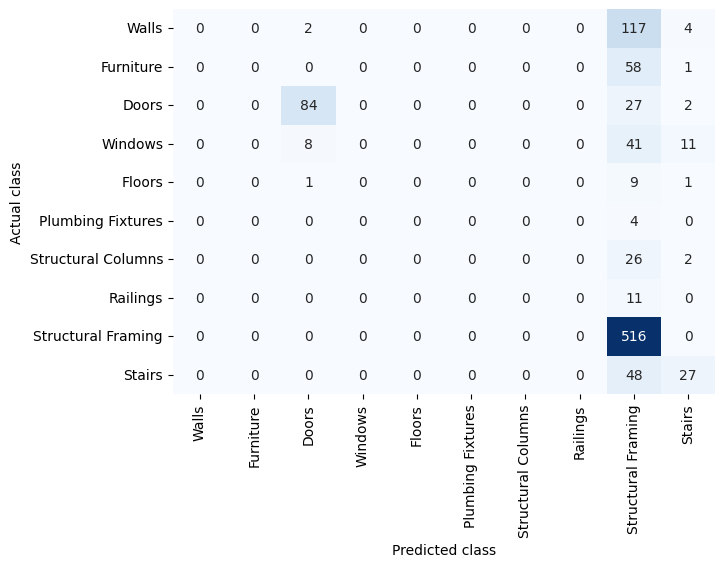

In [23]:
eval(hybrid_model, train_loader, device, class_names)

In [ ]:
eval(hybrid_model, val_loader, device, class_names)

  0%|▏                                                               | 27/8575 [00:52<4:28:23,  1.88s/it]

In [108]:
test_labels, test_probs = eval(model, test_loader, device,
                               class_names, fname="../reports/figures/mvcnn_confusion.png")

  2%|▌                       | 999/42874 [00:14<10:28, 66.67it/s]
/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/ifcnet-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2458: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/ifcnet-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/avishagnevo/Desktop/archi_project/ifcnet-models-master/ifcnet-env/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_p

[8 8 8 8 8 8 8 8 8 1 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 9
 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 9 9 8 9 9 8 8 8 8 9 8 8
 8 9 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9 9 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9 9 8 8 8 8 8 9 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9 9 8 8 8 8 2 8 2 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8
 9 9 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9
 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 9 8 8 8 8 8 8 8 8 9 9 9 8
 8 8 8 2 8 2 8 8 8 8 8 8 

ValueError: Shape of passed values is (7, 7), indices imply (10, 10)

In [98]:
np.savez("ArcGNNProbs.npz", labels=test_labels, probs=test_probs)

NameError: name 'test_labels' is not defined

In [ ]:
test_predictions = np.argmax(test_probs, axis=1)
wrong_predictions = np.where(test_labels != test_predictions)[0]